# Creando un master bias con ccdproc
## Imoprtando los módulos
Vamos a utilizar el módulo `ccdproc` para realizar la reducción de datos. Algunos de los submódulos y funciones definidos dentro de `ccdproc` son `substrac_overscan`, `CCDData`, `ImageFileCollection`, que utilizaremos.

También necesitamos importar la función `show_image` definida dentro del módulo llamado `functions.py`. Para que funcione, debes tener ese archivo en tu directorio actual de trabajo.

Utilizaremos el módulo `pathlib` y su función `Path` para trabajar con las rutas hacia los datos.

In [1]:
from ccdproc import CCDData, ImageFileCollection, subtract_overscan, trim_image, combine
from pathlib import Path
from functions import show_image

import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import mad_std

## Definiendo las rutas a los archivos
Recuerda que para que este Notebook funcione, la carpeta llamada `example-cryo-LFC` debe estar en tu directorio actual de trabajo. Puedes descargar dicha carpeta en este enlace: https://zenodo.org/records/3254683.

Ya que tienes la carpeta de datos en tu directorio actual de trabajo, definimos la ruta hacia los datos:

In [2]:
#- Definiendo la ruta a los datos
cryo_path = Path('example-cryo-LFC')

Vamos a seleccionar una imagen de bias, una de objeto y una de flat fields:

In [3]:
#- Leyendo unas cuantas imágenes
bias_lfc   = CCDData.read(cryo_path / 'ccd.001.0.fits', unit='count')
object_lfc = CCDData.read(cryo_path / 'ccd.037.0.fits' , unit='count')
flat_lfc   = CCDData.read(cryo_path / 'ccd.014.0.fits', unit='count')

In [4]:
#- Obteniendo la cantidad de pixeles
bias_lfc.shape

(4128, 2080)

## Visualizando la sección de overscan
La siguiente celda de código muestra una gráfica del comportamiento de los conteos a partir del pixel 2048, que corresponde al overscan del instrumento.

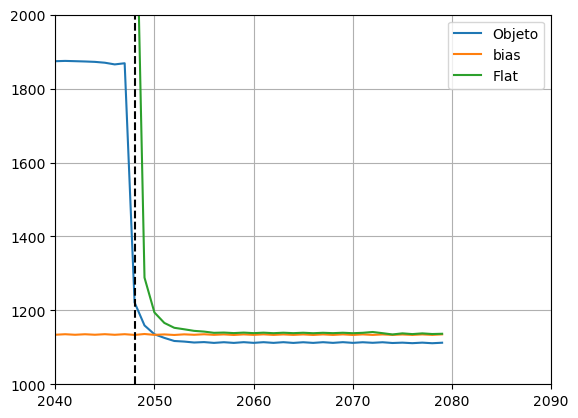

In [5]:

plt.plot(object_lfc.data.mean(axis=0), label='Objeto')
plt.plot(bias_lfc.data.mean(axis=0), label='bias')
plt.plot(flat_lfc.data.mean(axis=0), label='Flat')

plt.legend()
plt.grid()
plt.axvline(x=2048, c='black', ls='--', label='Overscan')

plt.ylim(1000, 2000)
plt.xlim(2040, 2090)
plt.show()

La gráfica nos dice que la intensidad se mantiene constante en la región del overscan. Esto significa que podemos restar ese valor constante para comenzar la calibración de imágenes. Primero notamos que el valor constante para los tres tipos de imágenes comienza a partir del pixel `2055` aproximadamente. Usaremos ese valor.

Comenzamos creando una carpeta donde se guardarán los datos que iremos calibrando:

In [6]:
#- Crea una nueva carpeta
calibrated_data = Path('.', 'example-reduced')
calibrated_data.mkdir(exist_ok=True)

## Creando una colección de imágenes
Vamos a leer todas las imágenes ubicadas en la carpeta de datos:

In [7]:
files = ImageFileCollection(cryo_path)

Podemos aplicar el atributo `summary` para mostrar en qué consiste la colección de imágenes que acabamos de crear:

In [8]:

files.summary

file,simple,bitpix,naxis,naxis1,naxis2,bscale,bzero,date,origin,latitude,longitud,telescop,fratio,instrume,detector,frame,ccdpicno,object,imagetyp,exptime,darktime,date-obs,ut,jd,ra,dec,equinox,epoch,ha,st,airmass,filter,gain,secpix1,secpix2,ccdbin1,ccdbin2,rotangle,datasec,ccdsec,biassec,loginfo,chipid
str14,bool,int64,int64,int64,int64,float64,float64,str10,str34,float64,float64,str17,float64,str3,str14,int64,int64,str7,str9,float64,float64,str10,str12,float64,str12,str12,float64,float64,str12,str12,float64,str2,float64,float64,float64,int64,int64,float64,str15,str15,str18,str18,int64
ccd.001.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-15,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,1,1,bias,BIAS,0.0,0.12,2016-01-15,23:53:30.00,2457403.495486,23:44:32.40,33:22:10.80,2000.0,2000.0,00:00:04.00,23:45:23.10,1.0,i',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:2080,1:4127]",Status=0x00000000,0
ccd.002.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-15,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,2,2,bias,BIAS,0.0,0.111,2016-01-15,23:55:29.00,2457403.496863,23:46:30.51,33:22:10.60,2000.0,2000.0,00:00:04.00,23:47:22.43,1.0,i',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:2080,1:4127]",Status=0x00000000,0
ccd.003.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-15,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,3,3,bias,BIAS,0.0,0.112,2016-01-15,23:57:27.00,2457403.498229,23:48:29.06,33:22:10.50,2000.0,2000.0,00:00:04.00,23:49:20.75,1.0,i',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:2080,1:4127]",Status=0x00000000,0
ccd.004.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-16,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,4,4,bias,BIAS,0.0,0.12,2016-01-15,23:59:25.00,2457403.499595,23:50:27.42,33:22:10.39,2000.0,2000.0,00:00:04.00,23:51:19.07,1.0,i',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:2080,1:4127]",Status=0x00000000,0
ccd.005.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-16,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,5,5,bias,BIAS,0.0,0.12,2016-01-16,00:01:23.00,2457403.500961,23:52:25.69,33:22:10.39,2000.0,2000.0,00:00:04.00,23:53:17.40,1.0,i',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:2080,1:4127]",Status=0x00000000,0
ccd.006.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-16,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,6,6,bias,BIAS,0.0,0.112,2016-01-16,00:03:21.00,2457403.502326,23:54:23.73,33:22:10.30,2000.0,2000.0,00:00:04.00,23:55:15.72,1.0,i',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:2080,1:4127]",Status=0x00000000,0
ccd.014.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-16,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,14,14,flat_g,FLATFIELD,70.001,70.673,2016-01-16,04:17:28.00,2457403.678796,04:08:58.50,33:25:12.69,2000.0,2000.0,00:00:04.00,04:10:04.46,1.0,g',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:2080,1:4127]",Status=0x00000000,0
ccd.015.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-16,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,15,15,flat_g,FLATFIELD,70.011,70.683,2016-01-16,04:20:35.00,2457403.680961,04:12:05.19,33:25:16.79,2000.0,2000.0,00:00:04.00,04:13:11.98,1.0,g',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:2080,1:4127]",Status=0x00000000,0
ccd.016.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-16,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,16,16,flat_g,FLATFIELD,70.001,70.684,2016-01-16,04:23:41.00,2457403.683113,04:15:12.00,33:25:20.79,2000.0,2000.0,00:00:04.00,04:16:18.49,1.0,g',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:20

Mostramos la información de únicamente algunos headers en la primera imagen de la colección:

In [9]:
files.summary['file', 'imagetyp', 'biassec', 'ccdsec', 'datasec'][0]

file,imagetyp,biassec,ccdsec,datasec
str14,str9,str18,str15,str15
ccd.001.0.fits,BIAS,"[2049:2080,1:4127]","[1:2048,1:4128]","[1:2048,1:4128]"


## Seleccionando las imágenes de BIAS
Seleccionamos únicamente las imágenes de bias en la colección:

In [10]:
biases = files.files_filtered(include_path=True, imagetyp='BIAS')
biases

['example-cryo-LFC/ccd.001.0.fits',
 'example-cryo-LFC/ccd.002.0.fits',
 'example-cryo-LFC/ccd.003.0.fits',
 'example-cryo-LFC/ccd.004.0.fits',
 'example-cryo-LFC/ccd.005.0.fits',
 'example-cryo-LFC/ccd.006.0.fits']

## Corrigiendo por overscan una sola imagen bias
Para comprender en qué consiste el procedimiento de corregir por overscan, lo aplicaremos solo a una imagen.
posteriormente lo aplicaremos a todas las imágenes usando un bucle `for`.

Seleccionamos la primera imagen de bias:

In [11]:
first_bias = CCDData.read(biases[0], unit='adu')

Ahora corregimos usando la función `substract_overscan()`:

In [12]:
bias_overscan_substracted = subtract_overscan(first_bias, overscan=first_bias[ : , 2055: ], median=True)

Con lo anterior restamos el overscan, pero la imagen sigue teniendo pixeles extra. Debemos recortarla usando la función `trim_image()`

In [13]:
trimmed_bias = trim_image(bias_overscan_substracted[ :, :2048])

Comparamos la imagen de bias inicial con la imagen corregida por overscan y además recortada. El efecto neto es que se redujo la intensidad en los conteos de cada pixel, como era de esperarse.

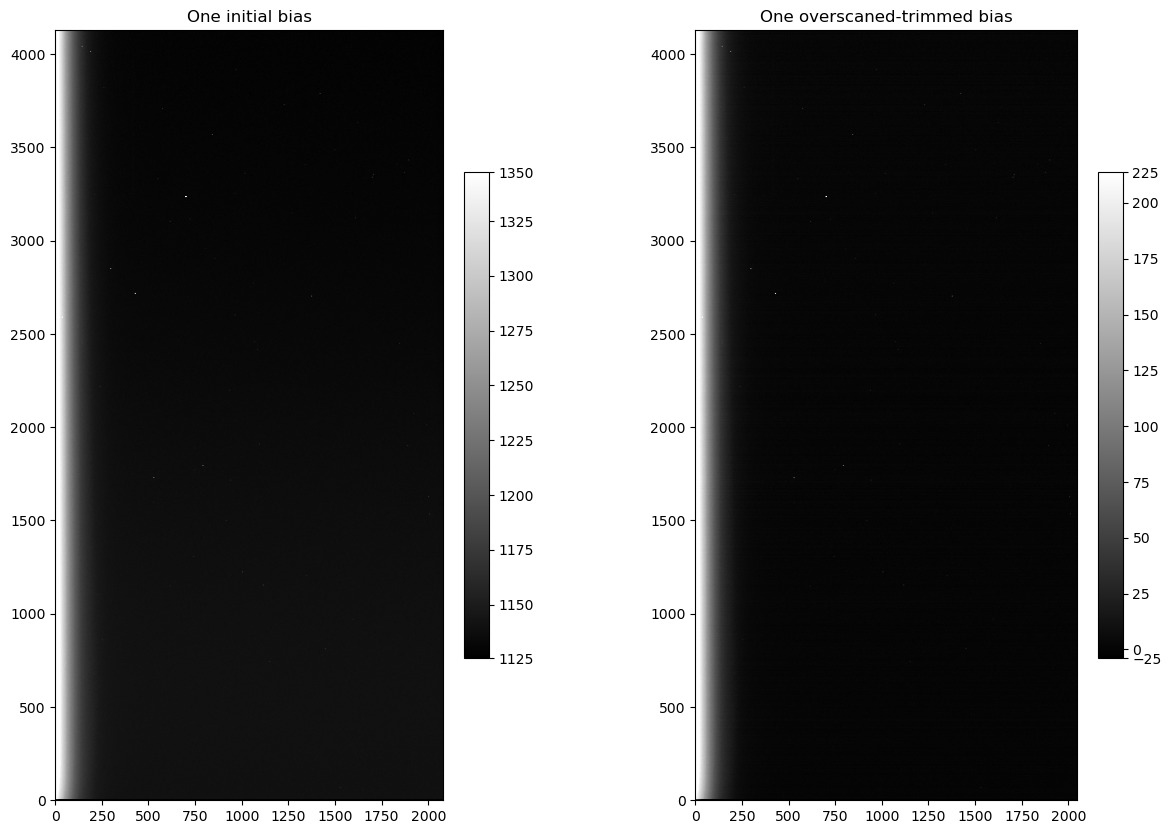

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

show_image(first_bias.data, cmap='gray', ax=ax1, fig=fig)
ax1.set_title('One initial bias')
show_image(trimmed_bias.data, cmap='gray', ax=ax2, fig=fig)
ax2.set_title('One overscaned-trimmed bias')
plt.show()

## Corrigiendo todas las imágenes de bias por overscan

In [15]:
#- Iterar sobre cada imagen
for ccd_file, file_name in files.ccds(imagetyp='BIAS', 
                                      ccd_kwargs={'unit': 'adu'}, 
                                      return_fname=True):

    #- Restar el oberscan
    ccd_file = subtract_overscan(ccd_file, overscan=ccd_file[: , 2055:], median = True)

    #- Recortar los archivos
    ccd_file = trim_image(ccd_file[:, :2048])

    #- Guardar el resultado
    ccd_file.write(calibrated_data / file_name , overwrite=True)

Vamos a ver algunas propiedades de los archivos recién creados:

In [16]:
reduced_images = ImageFileCollection(calibrated_data)

reduced_images.summary['file', 'imagetyp', 'naxis1', 'naxis2']

file,imagetyp,naxis1,naxis2
str28,str9,int64,int64
ccd.001.0.fits,BIAS,2048,4128
ccd.002.0.fits,BIAS,2048,4128
ccd.003.0.fits,BIAS,2048,4128
ccd.004.0.fits,BIAS,2048,4128
ccd.005.0.fits,BIAS,2048,4128
ccd.006.0.fits,BIAS,2048,4128
ccd.013.0.fits,DARK,2048,4128
ccd.014.0.fits,DARK,2048,4128
ccd.015.0.fits,DARK,2048,4128


# Creando el archivo master bias
Lo recomendable para combinar imágenes es obtener el promedio y descartar los valores extremos.

El módulo `ccdproc` ofrece la posibilidad de hacerlo mediante la función `combine`.

Primero seleccionamos las imágenes que acabamos de corregir por overscan:

In [17]:
calibrated_biases = reduced_images.files_filtered(imagetyp='bias', include_path=True)

In [18]:
calibrated_biases

['example-reduced/ccd.001.0.fits',
 'example-reduced/ccd.002.0.fits',
 'example-reduced/ccd.003.0.fits',
 'example-reduced/ccd.004.0.fits',
 'example-reduced/ccd.005.0.fits',
 'example-reduced/ccd.006.0.fits']

Y ahora los combinamos con `ccdproc.combine()`:

In [19]:
combined_bias = combine(calibrated_biases,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                             mem_limit=350e6
                            )

INFO:astropy:splitting each image into 7 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 7 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


Actualizamos la información del archivo:


In [20]:
combined_bias.meta['combined'] = True

Y ahora guardamos el archivo combinado:

In [21]:
combined_bias.write(calibrated_data / 'master_bias.fits')

## Visualizando el Master BIAS
Comparemos una sola imagen bias y el master bias usando la función `show_image`:

Text(0.5, 1.0, '6 bias images combined')

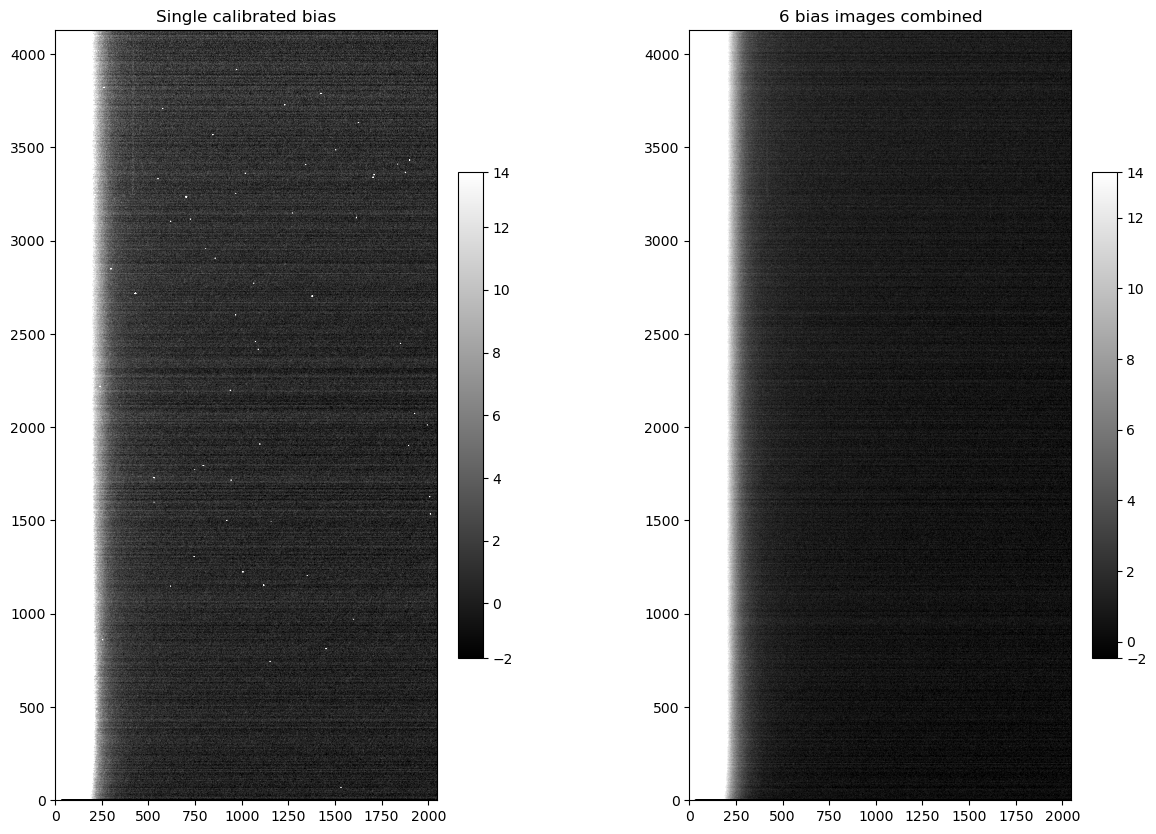

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

show_image(CCDData.read(calibrated_biases[0]).data, cmap='gray', ax=ax1, fig=fig, percl=90)
ax1.set_title('Single calibrated bias')
show_image(combined_bias.data, cmap='gray', ax=ax2, fig=fig, percl=90)
ax2.set_title('{} bias images combined'.format(len(calibrated_biases)))